In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gekko import GEKKO

from scipy.signal import savgol_filter

In [2]:
czantoria_full = pd.read_csv('data/csv/czantoria_sauce.csv')
czantoria_full.columns = ['time', 'distance', 'heartrate', 'cadence', 'velocity_smooth', 'altitude', 'grade_smooth']
czantoria_nonzero = czantoria_full[(czantoria_full['velocity_smooth'] > 0) | (czantoria_full['time'] == 0)]
czantoria_time = czantoria_nonzero.groupby('distance').agg({'time': 'max'}).reset_index()['time']
czantoria_final = pd.merge(czantoria_nonzero, czantoria_time, on=['time'])

In [3]:
distance_data = czantoria_final['distance'].to_numpy()
grade_data = czantoria_final['grade_smooth'].to_numpy()
elevation_data = czantoria_final['altitude'].to_numpy()

In [4]:
grade_smooth = savgol_filter(grade_data, 501, 1)

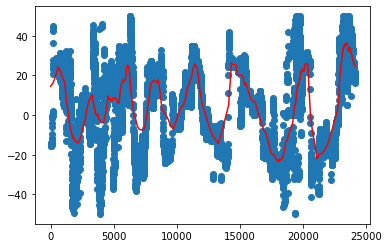

In [5]:
plt.scatter(distance_data, grade_data)
plt.plot(distance_data, grade_smooth, 'r')

In [6]:
# grade_data = np.arctan(grade_data/100)
# yhat = np.arctan(grade_smooth/100)
# plt.scatter(distance_data, grade_data)
# plt.plot(distance_data, yhat, 'r')

In [7]:
grade_data = grade_smooth

print(len(grade_data))

n = distance_data.shape[0]
to_stay = np.zeros(n)
to_stay[0] = 1

for i in range(n - 1):
    if np.abs(grade_data[i+1] - grade_data[i]) < 1.5:
        grade_data[i+1] = grade_data[i]
        to_stay[i+1] = 0
    elif np.sign(grade_data[i+1]) != np.sign(grade_data[i]):
        to_stay[i + 1] = 1
    else:
        to_stay[i + 1] = 1
        
to_stay[-1] = 1

grade_data = grade_data[to_stay == 1]
distance_data = distance_data[to_stay == 1]
elevation_data = elevation_data[to_stay == 1]

print(len(grade_data))

grade_data = np.arctan(grade_data/100)

13385
335


In [8]:
distance = distance_data[-1]

x_data = distance_data/(distance_data[-1])
slope_data = grade_data

# x_data = x_data[x_data <= distance]
# slope_data = slope_data[x_data <= distance]

In [9]:
# create GEKKO model
m = GEKKO()

In [10]:
t_est = 4 * 60 * 60
t_min = 1 * 60 * 60
t_max = 20 * 60 * 60

In [11]:
# constants
N_m = 0.0222
E0 = 1400
X = distance
tau = 0.67
g = 9.81
k = 0.03734
mass = 55
S = 22

In [12]:
# equation parts
alpha = (np.sqrt(S/tau) * X)/E0
beta = (4 * 4184 * 1/75 * N_m * X)/(E0 * np.sqrt(S * tau))
gamma = X/np.sqrt(S * tau**3)
delta = (g*X)/(S*tau)
mu = (k*N_m*X)/(np.sqrt(S*tau))

In [13]:
# scales
u_scale = np.sqrt(S/tau)
v_scale = np.sqrt(S*tau)
t_scale = X/v_scale

In [14]:
# scaled values
sigma0 = 1
e0 = 1
x0 = 0
v0 = 0
n0 = 0.00201818/N_m

e_crit = 0.15 * e0

In [15]:
# sigma data to create spline
E_data = np.linspace(0, e0, 1001)
sigma_data = sigma0 * E_data/(e0 * e_crit) + 0.75 * sigma0 * (1 - E_data/(e0 * e_crit))
sigma_data[E_data > e_crit] = sigma0

# slope data to create spline
# x_data = np.linspace(0, 1, 3000)
# slope_data = np.array(600*[1/18 * np.pi] + 600 * [-1/18 * np.pi] + 600*[1/36 * np.pi] + 600 * [-1/36 * np.pi] + 600 * [1/9 * np.pi])

In [16]:
# time points [s]
nt = 201
tm = np.linspace(0,1,nt)
m.time = tm

In [17]:
# Variables
v = m.Var(value=0.0, lb=0.0, ub=6/v_scale) #velocity
E = m.Var(value=e0, lb=0.0, ub=e0) #energy
x = m.Var(value=0.0) #horizontal coordinate
N = m.Var(value=n0, lb=0.0) # oxidation rate

sigma = m.Var(value=sigma0, lb=0) #breathing rate
slope = m.Var(value=slope_data[0]) #slope

p = np.zeros(nt)
p[-1] = 1.0
final = m.Param(value=p)

In [18]:
# FV - final time
# tf = m.FV(value=t_est/t_scale,lb=t_min/t_scale,ub=t_max/t_scale)
tf = m.FV(value=t_est/t_scale, lb = 0.1)
tf.STATUS = 1

In [19]:
# MV
u = m.MV(value=0,lb=0,ub=9.6/u_scale)
u.STATUS = 1

In [20]:
# energy decrease at the end
m.cspline(E, sigma, E_data, sigma_data, True)

# slope
m.cspline(x, slope, x_data, slope_data, True)

In [21]:
# equations
m.Equation(E.dt()==(alpha * (sigma - u * v) + beta * N)*tf)
m.Equation(v.dt()==(gamma * (u - v) - delta * m.sin(slope)) * tf)
m.Equation(x.dt()==(v*m.cos(slope))*tf)
m.Equation(N.dt()==(mu * N * (1 - N))*tf)
m.Equation(alpha * (sigma - u * v) + beta * N <= 0)
m.Equation((distance - X*x)*final<=0)

m.fix_final(E, 0)

In [22]:
m.options.IMODE = 6
m.options.MAX_ITER=30000
m.options.SOLVER=3
# m.options.RTOL=1e-4
# m.options.OTOL=1e-4

m.solve()

print('Final Time: ' + str(tf.value[0] * t_scale))

tm = tm * tf.value[0] * t_scale

apm 90.156.80.122_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            2
   Constants    :            0
   Variables    :           11
   Intermediates:            0
   Connections  :            6
   Equations    :            6
   Residuals    :            6
 
 Number of state variables:           3399
 Number of total equations: -         3200
 Number of slack variables: -          400
 ---------------------------------------
 Degrees of freedom       :           -201
 
 * Warning: DOF <= 0
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This 

  86r 8.4752394e-03 2.27e+04 1.06e+03  -9.0 5.26e-03   5.3 1.00e+00 3.98e-01f  1
  87r 8.4752394e-03 2.27e+04 1.06e+03  -9.0 1.57e-02   4.8 1.00e+00 1.36e-03f  1
  88r 8.4752394e-03 2.27e+04 1.06e+03  -9.0 4.70e-02   4.4 1.00e+00 2.42e-02f  1
  89r 8.4752394e-03 2.27e+04 1.05e+03  -9.0 1.41e-01   3.9 1.00e+00 1.19e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90r 8.4752394e-03 2.27e+04 1.05e+03  -9.0 5.28e-02   4.3 1.00e+00 3.20e-03f  1
  91r 8.4752394e-03 2.27e+04 1.05e+03  -9.0 1.63e-01   3.8 1.00e+00 1.84e-05f  1
  92r 8.4752394e-03 2.27e+04 1.05e+03  -9.0 6.13e-02   4.3 1.00e+00 1.63e-02f  1
  93r 8.4752394e-03 2.27e+04 1.05e+03  -9.0 1.85e-01   3.8 1.00e+00 5.22e-03f  1
  94r 8.4752394e-03 2.27e+04 1.05e+03  -9.0 6.87e-02   4.2 1.00e+00 2.80e-02f  1
  95r 8.4752394e-03 2.27e+04 1.05e+03  -5.3 2.42e-01   3.7 1.00e+00 1.51e-02f  1
  96r 8.4752394e-03 2.27e+04 1.05e+03  -4.4 7.99e-02   4.2 1.00e+00 2.84e-02f  1
  97r 8.4752393e-03 2.27e+04

 214r 1.6135296e-02 2.11e+04 4.84e+03  -0.3 5.05e-03   6.0 1.00e+00 1.00e+00f  1
 215r 1.6135316e-02 2.11e+04 2.84e+03  -1.1 5.69e-03   5.5 1.00e+00 6.62e-01f  1
 216r 1.6135318e-02 2.11e+04 2.15e+03  -1.8 1.83e-03   5.9 1.00e+00 5.38e-01f  1
 217r 1.6135323e-02 2.11e+04 1.90e+03  -1.8 5.27e-03   5.5 1.00e+00 3.89e-01f  1
 218r 1.6135344e-02 2.11e+04 1.90e+03  -1.0 2.02e-02   5.0 9.85e-01 1.86e-01f  1
 219r 1.6135416e-02 2.11e+04 1.90e+03  -0.8 6.13e-02   4.5 9.34e-01 1.16e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220r 1.6135726e-02 2.10e+04 1.90e+03  -0.6 1.78e-01   4.0 9.53e-01 1.09e-01f  1
 221r 1.6136931e-02 2.10e+04 1.89e+03  -0.4 4.99e-01   3.5 9.87e-01 9.55e-02f  1
 222r 1.6144386e-02 2.10e+04 1.84e+03  -0.0 1.16e+00   3.1 9.37e-01 8.21e-02f  1
 223r 1.6146796e-02 2.10e+04 1.70e+03  -0.9 3.25e+00   2.6 3.50e-01 7.24e-02f  1
 224r 1.6235277e-02 2.10e+04 1.51e+03   0.9 1.18e+02   2.1 2.05e-02 1.15e-02f  1
 225r 1.6450179e-02 2.09e+04

 352r 1.6467185e-02 2.07e+04 1.66e+04  -0.5 3.01e-03   6.1 2.65e-01 1.00e+00f  1
 353r 1.6467191e-02 2.07e+04 3.08e+03  -0.7 8.32e-04   6.5 1.00e+00 9.07e-01f  1
 354r 1.6467197e-02 2.07e+04 3.33e+03  -1.2 1.37e-03   6.0 1.00e+00 8.61e-01f  1
 355r 1.6467198e-02 2.07e+04 2.88e+03  -1.9 4.33e-03   5.5 1.00e+00 3.34e-01f  1
 356r 1.6467216e-02 2.07e+04 2.07e+03   0.3 1.47e-01   5.1 1.06e-01 8.61e-03f  1
 357r 1.6467221e-02 2.07e+04 2.13e+03  -0.9 4.81e-03   5.5 8.02e-02 1.45e-01f  1
 358r 1.6467251e-02 2.07e+04 2.07e+03  -1.1 1.43e-02   5.0 1.00e+00 3.77e-01f  1
 359r 1.6468920e-02 2.07e+04 2.29e+03  -0.1 3.94e-02   4.5 6.80e-01 6.61e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 360r 1.6469058e-02 2.07e+04 9.56e+03  -0.0 2.60e-03   5.9 1.00e+00 9.07e-01f  1
 361r 1.6469066e-02 2.07e+04 6.72e+03  -1.2 5.88e-03   5.4 1.00e+00 3.09e-01f  1
 362r 1.6469531e-02 2.07e+04 2.55e+03   0.4 3.96e-03   5.8 1.00e+00 1.00e+00f  1
 363r 1.6469539e-02 2.07e+04

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 490r 1.6497971e-02 2.06e+04 6.25e+03  -1.0 2.38e-03   6.1 2.23e-01 4.94e-01f  1
 491r 1.6497974e-02 2.06e+04 4.87e+03  -1.3 3.00e-03   5.7 8.94e-01 2.31e-01f  1
 492r 1.6498008e-02 2.06e+04 6.83e+03  -0.4 1.14e-03   6.1 1.00e+00 1.00e+00f  1
 493r 1.6498035e-02 2.06e+04 4.22e+03  -0.1 5.46e-04   6.5 1.00e+00 1.00e+00f  1
 494r 1.6498034e-02 2.06e+04 2.76e+03  -2.0 1.17e-03   6.0 1.00e+00 1.00e+00f  1
 495r 1.6498034e-02 2.06e+04 1.26e+03  -3.0 4.24e-04   6.5 1.00e+00 8.23e-01f  1
 496r 1.6498034e-02 2.06e+04 2.90e+03  -3.0 1.40e-03   6.0 1.00e+00 4.52e-01f  1
 497r 1.6498035e-02 2.06e+04 1.36e+03  -3.0 5.30e-04   6.4 1.00e+00 6.17e-01f  1
 498r 1.6498035e-02 2.06e+04 2.27e+03  -2.7 1.64e-03   5.9 1.00e+00 3.41e-01f  1
 499r 1.6498035e-02 2.06e+04 1.84e+03  -3.6 6.11e-04   6.4 1.00e+00 2.57e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500r 1.6498035e-02 2.06e+04

 582r 1.6630093e-02 2.04e+04 1.17e+03  -6.0 3.11e-03   5.6 1.00e+00 5.72e-02f  1
 583r 1.6630093e-02 2.04e+04 1.06e+03  -5.4 1.13e-03   6.0 1.00e+00 1.70e-01f  1
 584r 1.6630093e-02 2.04e+04 1.05e+03  -5.4 3.64e-03   5.5 1.00e+00 5.98e-02f  1
 585r 1.6630093e-02 2.04e+04 1.05e+03  -4.9 1.35e-03   6.0 1.00e+00 1.03e-01f  1
 586r 1.6630093e-02 2.04e+04 1.07e+03  -4.6 4.05e-03   5.5 1.00e+00 6.42e-02f  1
 587r 1.6630093e-02 2.04e+04 1.09e+03  -4.5 1.53e-03   5.9 1.00e+00 1.04e-01f  1
 588r 1.6630093e-02 2.04e+04 1.12e+03  -3.3 5.65e-04   6.3 1.00e+00 1.87e-01f  1
 589r 1.6630094e-02 2.04e+04 1.20e+03  -4.0 1.77e-03   5.9 1.00e+00 9.24e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 590r 1.6630095e-02 2.04e+04 1.18e+03  -3.1 7.44e-04   6.3 1.00e+00 1.93e-01f  1
 591r 1.6630096e-02 2.04e+04 1.32e+03  -3.5 1.94e-03   5.8 1.00e+00 7.63e-02f  1
 592r 1.6630096e-02 2.04e+04 1.21e+03  -3.5 7.19e-04   6.2 1.00e+00 2.46e-01f  1
 593r 1.6630096e-02 2.04e+04

 686r 2.0875891e-02 1.72e+04 9.99e+02   1.9 0.00e+00    -  0.00e+00 3.00e-07R  6
 687r 2.1416421e-02 1.62e+04 9.96e+02   1.0 1.05e+04    -  8.62e-03 3.28e-03f  1
 688r 2.8661183e-02 1.60e+04 1.08e+03   1.7 7.15e+02   0.0 5.18e-02 7.99e-03f  1
 689r 2.8682645e-02 1.60e+04 3.63e+03   1.4 1.74e+00   4.0 1.20e-01 1.48e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 690r 2.8702538e-02 1.60e+04 1.98e+04   1.4 9.66e-01   4.5 1.01e-01 2.99e-01f  1
 691r 2.8733151e-02 1.60e+04 7.16e+04   2.1 8.21e-01   4.9 9.23e-01 2.57e-01f  1
 692r 2.8767633e-02 1.60e+04 7.48e+04   2.4 4.95e-01   5.3 1.00e+00 4.57e-01f  1
 693r 2.8775522e-02 1.60e+04 1.05e+05   2.1 2.55e-01   5.7 1.00e+00 5.59e-01h  1
 694r 2.8780743e-02 1.60e+04 8.29e+04   1.2 1.16e-01   5.3 1.00e+00 1.00e+00f  1
 695r 2.8784902e-02 1.60e+04 2.91e+03   0.6 2.14e-02   4.8 1.00e+00 1.00e+00f  1
 696r 2.8784850e-02 1.60e+04 1.12e+03  -1.3 6.81e-03   5.2 1.00e+00 1.00e+00f  1
 697r 2.8784840e-02 1.60e+04

 824  3.2902810e-02 1.36e+04 9.03e+03  -0.3 2.98e+03    -  2.53e-02 2.30e-04h  1
 825  3.2919571e-02 1.36e+04 9.03e+03  -0.3 3.20e+03    -  6.27e-04 4.86e-04h  1
 826  3.3165322e-02 1.35e+04 8.27e+03  -0.3 3.12e+03    -  1.90e-02 7.12e-03f  1
 827  3.3174523e-02 1.35e+04 8.27e+03  -0.3 3.14e+03    -  9.18e-03 2.41e-04h  1
 828r 3.3174523e-02 1.35e+04 9.99e+02   1.7 0.00e+00    -  0.00e+00 2.63e-07R  6
 829r 5.0300780e-02 1.31e+04 1.09e+03   2.7 5.97e+03    -  1.31e-02 3.10e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 830r 5.0418337e-02 1.31e+04 3.70e+04   1.6 5.55e-01   4.0 3.98e-01 1.00e+00f  1
 831r 5.0420624e-02 1.31e+04 4.45e+04   1.4 6.42e-02   5.3 1.00e+00 5.09e-01f  1
 832r 5.0421333e-02 1.31e+04 1.07e+05   1.1 1.90e-02   5.8 1.00e+00 1.00e+00f  1
 833r 5.0421380e-02 1.31e+04 6.16e+05   0.5 2.57e-02   6.2 1.00e+00 1.00e+00f  1
 834r 5.0421466e-02 1.31e+04 1.04e+06   1.0 4.32e-02   6.6 1.00e+00 1.00e+00f  1
 835r 5.0421481e-02 1.31e+04

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 920r 5.0521872e-02 1.30e+04 3.11e+03   1.0 1.30e-01   4.4 1.64e-01 4.09e-01f  1
 921r 5.0525906e-02 1.30e+04 1.59e+04   1.0 5.44e-02   4.8 6.05e-01 8.46e-01f  1
 922r 5.0535863e-02 1.30e+04 6.35e+03   1.0 5.04e-02   4.4 1.00e+00 6.94e-01f  1
 923r 5.0542147e-02 1.30e+04 1.01e+04   1.0 1.24e+00   3.9 5.47e-02 1.46e-01f  1
 924r 5.0542605e-02 1.30e+04 1.74e+04   1.2 1.20e-01   5.2 1.00e+00 1.22e-01f  1
 925r 5.0545400e-02 1.30e+04 1.62e+05   1.1 1.65e-01   4.7 1.14e-01 3.55e-01f  1
 926r 5.0545790e-02 1.30e+04 9.57e+04   1.1 4.18e-01   5.2 1.83e-01 1.30e-01f  1
 927r 5.0546016e-02 1.30e+04 9.20e+04   1.1 1.94e-01   4.7 7.68e-03 2.52e-02f  1
 928r 5.0558887e-02 1.30e+04 6.83e+03   1.1 3.92e-01   4.2 8.92e-01 4.77e-01f  1
 929r 5.0586374e-02 1.29e+04 6.39e+03   0.9 2.15e-01   3.7 7.05e-01 5.94e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 930r 5.0587343e-02 1.29e+04

1035r 5.9069440e-02 9.82e+03 4.50e+03  -0.6 9.56e-03   5.2 1.00e+00 3.96e-01f  1
1036r 5.9069440e-02 9.82e+03 3.18e+03  -6.6 2.88e-02   4.7 2.39e-01 5.88e-02f  1
1037r 5.9069498e-02 9.82e+03 5.95e+03  -0.5 1.00e-02   5.1 1.00e+00 6.37e-01f  1
1038r 5.9069497e-02 9.82e+03 5.04e+03  -6.5 3.64e-02   4.6 2.23e-01 1.38e-01f  1
1039r 5.9070598e-02 9.82e+03 1.58e+04   1.4 3.49e+00   4.2 3.40e-02 1.82e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1040r 5.9070607e-02 9.82e+03 1.52e+04  -0.1 1.07e-02   5.5 7.84e-01 1.18e-01f  1
1041r 5.9070804e-02 9.82e+03 4.73e+03  -0.1 2.24e-02   5.0 8.66e-01 7.92e-01f  1
1042r 5.9071096e-02 9.82e+03 9.14e+03   0.4 9.78e-03   5.4 1.00e+00 1.00e+00f  1
1043r 5.9071160e-02 9.82e+03 7.57e+03   0.3 6.45e-03   5.9 6.14e-01 6.74e-01f  1
1044r 5.9071249e-02 9.81e+03 6.26e+03  -0.2 4.76e-03   5.4 1.00e+00 9.90e-01f  1
1045r 5.9072357e-02 9.81e+03 1.70e+04   0.5 5.24e-02   4.9 5.09e-01 8.29e-01f  1
1046r 5.9072430e-02 9.81e+03

1131  8.8056950e-02 6.42e+03 2.59e+04   0.1 1.31e+03    -  6.75e-03 9.08e-03f  1
1132  9.1321499e-02 6.18e+03 1.66e+05   0.1 1.70e+03    -  4.07e-02 3.75e-02f  1
1133  9.1432708e-02 6.17e+03 1.65e+05   0.1 1.48e+03    -  4.79e-02 1.21e-03h  1
1134  9.1465997e-02 6.17e+03 1.65e+05   0.1 3.86e+03    -  8.25e-04 3.48e-04h  1
1135  9.1565333e-02 6.17e+03 1.65e+05   0.1 2.75e+04    -  3.80e-05 1.18e-03h  1
1136  9.1583280e-02 6.16e+03 1.65e+05   0.1 2.69e+04    -  2.34e-04 2.14e-04h  2
1137  9.2197772e-02 6.12e+03 1.64e+05   0.1 1.02e+04    -  2.56e-05 6.49e-03h  1
1138  9.2203609e-02 6.12e+03 1.64e+05   0.1 1.80e+04    -  7.73e-04 5.65e-05h  1
1139  9.2237879e-02 6.12e+03 1.64e+05   0.1 4.30e+04    -  2.15e-04 3.23e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1140  9.2300953e-02 6.12e+03 1.64e+05   0.1 1.08e+04    -  2.62e-04 6.19e-04h  1
1141  9.2338607e-02 6.12e+03 1.64e+05   0.1 3.15e+04    -  3.03e-04 3.67e-04h  1
1142  9.2373385e-02 6.11e+03

1241  1.4301853e-01 3.76e+03 3.78e+03  -0.1 2.92e+03  -2.0 4.03e-03 1.22e-02h  1
1242  1.4445652e-01 3.64e+03 1.52e+04  -0.1 1.98e+03    -  3.72e-02 3.02e-02f  2
1243  1.4506865e-01 3.60e+03 1.46e+04  -0.1 3.90e+03    -  1.30e-02 1.22e-02f  1
1244  1.4840810e-01 3.37e+03 1.34e+04  -0.1 1.42e+03    -  3.79e-02 6.44e-02f  1
1245  1.4842042e-01 3.37e+03 1.34e+04  -0.1 1.65e+03    -  1.47e-02 2.25e-04h  1
1246  1.4842633e-01 3.37e+03 1.34e+04  -0.1 1.61e+04    -  3.46e-04 9.16e-05h  1
1247  1.4889539e-01 3.34e+03 1.33e+04  -0.1 1.07e+04    -  7.53e-05 8.15e-03h  1
1248  1.4930020e-01 3.32e+03 1.32e+04  -0.1 5.97e+03    -  2.20e-03 7.12e-03f  1
1249  1.4942800e-01 3.31e+03 1.31e+04  -0.1 4.51e+03    -  4.83e-02 2.24e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1250  1.5016585e-01 3.27e+03 1.29e+04  -0.1 4.50e+03    -  1.59e-02 1.23e-02f  1
1251  1.5019334e-01 3.27e+03 1.47e+04  -0.1 4.25e+03    -  9.31e-02 4.59e-04h  1
1252  1.5024877e-01 3.26e+03

1339r 2.2231624e-01 1.09e+02 2.25e+04  -0.7 2.90e-02   4.7 1.00e+00 1.98e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1340r 2.2231626e-01 1.09e+02 5.98e+04  -0.5 6.39e-02   4.2 1.00e+00 9.02e-02f  1
1341r 2.2231628e-01 1.09e+02 1.63e+04  -0.9 2.35e-02   4.6 1.00e+00 7.14e-01f  1
1342r 2.2231632e-01 1.09e+02 8.74e+03  -0.1 1.68e-02   5.1 1.00e+00 7.01e-01f  1
1343r 2.2231633e-01 1.09e+02 1.14e+03  -0.5 3.75e-03   5.5 1.00e+00 9.77e-01f  1
1344r 2.2231633e-01 1.09e+02 1.31e+03  -1.1 1.16e-02   5.0 1.00e+00 8.37e-01f  1
1345r 2.2231635e-01 1.09e+02 5.29e+03  -0.8 4.65e-02   4.5 1.00e+00 3.29e-01f  1
1346r 2.2231637e-01 1.09e+02 1.15e+03  -0.6 1.28e-02   5.0 1.00e+00 9.17e-01f  1
1347r 2.2231638e-01 1.09e+02 1.41e+03  -0.7 4.95e-03   5.4 1.00e+00 1.00e+00f  1
1348r 2.2231640e-01 1.09e+02 1.32e+03  -0.4 1.57e-02   4.9 1.00e+00 6.18e-01f  1
1349r 2.2231642e-01 1.09e+02 1.34e+03  -0.6 6.98e-02   4.4 5.43e-01 1.89e-01f  1
iter    objective    inf_pr 

1477r 2.2234022e-01 1.08e+02 9.05e+02  -1.3 1.69e-02   3.0 1.00e+00 8.15e-01f  1
1478r 2.2234027e-01 1.08e+02 8.51e+02  -1.5 4.66e-02   2.5 1.40e-01 5.88e-02f  1
1479r 2.2234027e-01 1.08e+02 1.05e+03  -1.5 3.25e-03   4.7 6.77e-01 7.05e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1480r 2.2234027e-01 1.08e+02 9.17e+02  -2.2 1.55e-03   4.2 1.00e+00 8.54e-01f  1
1481r 2.2234028e-01 1.08e+02 1.09e+03  -2.4 3.32e-03   3.8 1.00e+00 8.37e-01f  1
1482r 2.2234028e-01 1.08e+02 4.68e+02  -3.0 3.16e-03   4.2 1.00e+00 7.84e-01f  1
1483r 2.2234028e-01 1.08e+02 1.04e+03  -3.3 6.95e-04   4.6 1.00e+00 8.47e-01f  1
1484r 2.2234028e-01 1.08e+02 8.25e+02  -2.6 3.32e-03   4.1 1.00e+00 2.00e-01f  1
1485r 2.2234028e-01 1.08e+02 8.04e+02  -3.0 3.35e-03   3.7 1.00e+00 5.64e-01f  1
1486r 2.2234028e-01 1.08e+02 6.64e+02  -3.5 9.55e-03   3.2 1.00e+00 1.74e-01f  1
1487r 2.2234028e-01 1.08e+02 5.79e+02  -2.9 2.85e-02   2.7 1.00e+00 1.29e-01f  1
1488r 2.2234035e-01 1.08e+02

1574  2.7998866e-01 1.38e+03 3.47e+06   0.1 1.18e+04    -  5.60e-05 1.05e-03f  2
1575  2.7998866e-01 1.38e+03 1.52e+09   0.1 8.42e-02  10.8 1.00e+00 7.85e-05h  1
1576  2.7998866e-01 5.83e+01 1.98e+09   0.1 8.64e-02  10.4 1.00e+00 1.00e+00f  1
1577  2.7998866e-01 5.00e+01 1.02e+09   0.1 2.15e-03  11.7 1.00e+00 8.79e-01h  1
1578  2.7998866e-01 5.00e+01 4.34e+08   0.1 6.89e-03  11.2 1.00e+00 1.00e+00f  1
1579  2.7998866e-01 5.00e+01 2.24e+08   0.1 2.50e-02  10.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1580  2.7998866e-01 5.00e+01 5.34e+08   0.1 2.77e-03  11.2 1.00e+00 1.00e+00h  1
1581  2.7998866e-01 5.00e+01 5.45e+08   0.1 1.22e-03  11.6 1.00e+00 1.00e+00h  1
1582  2.7998866e-01 5.00e+01 6.90e+08   0.1 6.74e-04  12.0 1.00e+00 1.00e+00h  1
1583  2.7998866e-01 5.00e+01 7.68e+08   0.1 3.13e-03  11.5 1.00e+00 1.00e+00h  1
1584  2.7998866e-01 5.00e+01 1.42e+09   0.1 1.98e-01  11.1 1.00e+00 1.00e+00h  1
1585  2.7998866e-01 5.00e+01

1685r 2.9439604e-01 4.30e+01 1.30e+03   0.5 4.10e-03   4.5 1.00e+00 1.00e+00f  1
1686r 2.9439824e-01 4.30e+01 1.08e+03   0.5 7.45e-03   4.0 1.00e+00 1.00e+00f  1
1687r 2.9440481e-01 4.30e+01 1.30e+03   0.5 1.01e-02   3.5 1.00e+00 1.00e+00f  1
1688r 2.9442453e-01 4.30e+01 1.08e+03   0.5 7.14e-03   3.0 1.00e+00 1.00e+00f  1
1689r 2.9448366e-01 4.30e+01 1.25e+03   0.5 1.83e-02   2.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1690r 2.9466071e-01 4.29e+01 1.09e+03   0.5 5.38e-02   2.1 1.00e+00 1.00e+00f  1
1691r 2.9518880e-01 4.28e+01 1.13e+03   0.5 1.54e-01   1.6 1.00e+00 1.00e+00f  1
1692r 2.9674620e-01 4.26e+01 2.36e+03   0.5 4.15e-01   1.1 1.00e+00 1.00e+00f  1
1693r 2.9674628e-01 4.26e+01 1.53e+03   0.5 1.91e-01   4.3 3.57e-01 6.39e-02h  1
1694r 2.9674970e-01 4.26e+01 8.50e+02   0.5 9.13e-03   3.8 1.00e+00 1.00e+00f  1
1695r 2.9675996e-01 4.26e+01 1.05e+03   0.5 8.18e-03   3.3 1.00e+00 1.00e+00f  1
1696r 2.9679075e-01 4.26e+01

1779  3.6400466e-01 3.28e+02 1.16e+03  -0.4 1.26e+03    -  8.22e-02 5.52e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1780  3.6541109e-01 3.23e+02 1.15e+03  -0.4 6.95e+02    -  1.08e-02 1.43e-02h  4
1781  3.6541109e-01 3.23e+02 4.70e+10  -0.4 8.71e-07  16.7 9.97e-01 1.00e+00h  1
1782  3.6541109e-01 3.23e+02 9.39e+10  -0.4 5.23e-06  16.3 1.00e+00 1.00e+00h  1
1783  3.6541109e-01 3.23e+02 1.41e+11  -0.4 2.35e-05  15.8 1.00e+00 1.00e+00h  1
1784  3.6541109e-01 3.23e+02 1.87e+11  -0.4 9.37e-05  15.3 1.00e+00 1.00e+00h  1
1785  3.6541109e-01 3.22e+02 2.32e+11  -0.4 3.49e-04  14.8 1.00e+00 1.00e+00h  1
1786  3.6541109e-01 3.18e+02 2.71e+11  -0.4 1.22e-03  14.3 1.00e+00 1.00e+00h  1
1787  3.6541109e-01 3.07e+02 2.93e+11  -0.4 3.96e-03  13.9 1.00e+00 1.00e+00h  1
1788  3.6541109e-01 2.79e+02 2.59e+11  -0.4 1.08e-02  13.4 1.00e+00 7.50e-01H  1
1789  3.6541109e-01 2.78e+02 2.59e+11  -0.4 1.99e-02  12.9 2.77e-03 2.77e-03s 14
iter    objective    inf_pr 

1873  4.1563891e-01 2.56e+01 7.80e+06  -0.4 4.23e+01   2.2 2.60e-01 1.18e-01h  1
1874  4.1563891e-01 2.44e+01 4.58e+07  -0.4 1.23e+00   6.3 6.01e-01 4.84e-02h  1
1875r 4.1563891e-01 2.44e+01 1.00e+03   0.2 0.00e+00   5.8 0.00e+00 4.53e-07R  4
1876r 4.1628837e-01 2.34e+01 4.48e+03   1.0 1.42e+03    -  9.08e-02 1.06e-03f  1
1877  4.1685383e-01 2.81e+01 1.05e+02  -0.4 5.90e+02    -  1.12e-01 3.62e-02f  3
1878  4.1722268e-01 2.72e+01 3.26e+02  -0.4 6.83e+02    -  1.76e-01 2.09e-02f  4
1879  4.1744356e-01 2.68e+01 3.59e+02  -0.4 4.79e+02    -  3.41e-02 1.03e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1880  4.1774260e-01 2.61e+01 6.32e+02  -0.4 4.57e+02    -  1.97e-01 1.34e-02f  5
1881  4.1793120e-01 2.59e+01 9.99e+02  -0.4 4.81e+02    -  2.42e-01 6.81e-03f  6
1882  4.2557725e-01 4.44e+02 7.48e+02  -0.4 5.51e+02    -  1.83e-01 2.09e-01f  1
1883  4.2722058e-01 4.28e+02 2.09e+03  -0.4 8.27e+02    -  7.52e-03 3.70e-02h  1
1884  4.3019771e-01 4.04e+02

1971  1.0691400e+00 8.65e-01 6.76e+08  -2.5 5.74e+02    -  2.77e-03 4.50e-01f  1
1972  1.0691400e+00 8.65e-01 6.76e+08  -3.5 1.58e+00  11.5 3.24e-04 3.26e-04h  1
1973  1.0691400e+00 8.62e-01 9.03e+09  -3.5 2.47e-06  15.6 1.00e+00 1.00e+00h  1
1974  1.0691400e+00 8.49e-01 1.54e+10  -3.5 1.45e-05  15.1 2.58e-01 7.45e-01h  1
1975  1.0691400e+00 8.40e-01 2.39e+10  -3.5 7.38e-06  15.5 1.00e+00 1.00e+00h  1
1976  1.0691400e+00 8.04e-01 4.59e+10  -3.5 3.76e-05  15.0 1.00e+00 1.00e+00h  1
1977  1.0691400e+00 7.88e-01 8.65e+10  -3.5 2.89e-05  15.5 1.00e+00 1.00e+00h  1
1978  1.0691400e+00 7.80e-01 1.08e+11  -3.5 1.40e-05  15.9 1.00e+00 1.00e+00h  1
1979  1.0691400e+00 7.64e-01 2.51e+11  -3.5 1.14e-04  15.4 1.00e+00 6.62e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1980  1.0691400e+00 7.53e-01 3.79e+11  -3.5 5.39e-05  15.8 1.00e+00 1.00e+00h  1
1981  1.0691400e+00 7.49e-01 4.43e+11  -3.5 2.42e-05  16.3 1.00e+00 1.00e+00h  1
1982  1.0691400e+00 7.35e-01

Final Time: 6281.046441409396


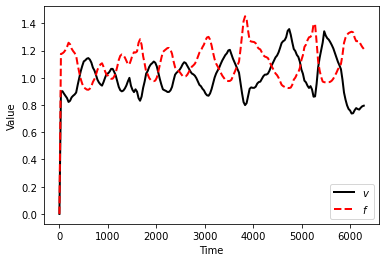

In [23]:
plt.figure(1)
plt.plot(tm,v.value,'k-',lw=2,label=r'$v$')
plt.plot(tm,u.value,'r--',lw=2,label=r'$f$')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

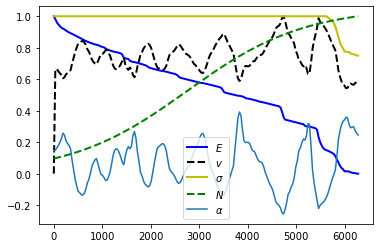

In [24]:
plt.figure(2)
plt.plot(tm,np.array(E.value)/max(E.value),'b-',lw=2,label=r'$E$')
plt.plot(tm,np.array(v.value)/max(v.value),'k--',lw=2,label=r'$v$')
plt.plot(tm, np.array(sigma.value)/max(sigma.value), 'y-', lw=2, label=r'$\sigma$')
plt.plot(tm, np.array(N.value)/max(N.value), 'g--', lw=2, label=r'$N$')
plt.plot(tm,slope, label=r'$\alpha$')
plt.legend()
plt.show()

In [25]:
6281/3600

1.7447222222222223

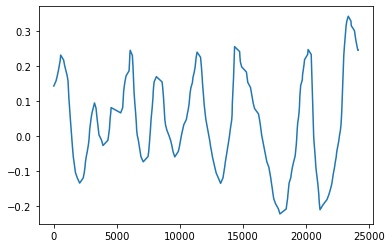

In [26]:
plt.plot(distance_data, grade_data)